In [1]:
%load_ext autoreload
%autoreload 2

#<font color='orange'>Basics</font>

In [2]:
seeds = [120054, 388388, 570334, 907360, 938870]
percent_bads = [0.7, 0.8, 0.9, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.36, 0.4]
sizes = [1000, 5000, 10000]
contaminations = [0.12, ]#0.13, 0.14, 0.15, 0.16, 0.18, 0.2, ]#0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4]

len(seeds)*len(percent_bads)*len(sizes)*len(contaminations)#*12/1024#*2/60

285

In [3]:
#@title **Location** of the dataset
path =  "../data/HomeCredit/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"
ri_datasets_path = "../data/riData/"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import joblib
import sys
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.metrics import (roc_auc_score)
from sklearn.model_selection import KFold


In [5]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

In [7]:
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri

from submodules.topsis_python import topsis as top
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
import seaborn as sns

In [8]:
!du -sh ../data/riData/Models/TN-2010/*

657M	../data/riData/Models/TN-2010/120055
656M	../data/riData/Models/TN-2010/388389
656M	../data/riData/Models/TN-2010/570335
657M	../data/riData/Models/TN-2010/907361
656M	../data/riData/Models/TN-2010/938871


In [9]:
ls -l -h ../data/riData/Models/TN-2009/

total 20K
drwxr-sr-x 2 athyrson.ribeiro recod 4.0K May 25 15:45 120054/
drwxr-sr-x 2 athyrson.ribeiro recod 4.0K May 26 16:30 388388/
drwxr-sr-x 2 athyrson.ribeiro recod 4.0K May 26 17:51 570334/
drwxr-sr-x 2 athyrson.ribeiro recod 4.0K May 26 19:16 907360/
drwxr-sr-x 2 athyrson.ribeiro recod 4.0K May 26 20:32 938870/


In [10]:
!find ../data/riData/Models -type f | wc -l

580


In [11]:
seeds = [120054, 388388, 570334, 907360, 938870]
year = 2009
file_init = pd.DataFrame()

for seed_number in seeds:
    year = year + (year - 2009)
    folder = os.path.join(ri_datasets_path,f'Data/TN-{year}/{seed_number}/')
    print(f'there are {len(os.listdir(folder))} files in {folder}')

    for file in os.listdir(folder):
        if file_init.shape == (0,0):
            file_init = pd.read_parquet(os.path.join(folder, file))
        filename = os.path.join(folder, file)
        try:
            pd.read_parquet(filename).shape == file_init.shape
        except Exception as e:
            print(f'Error in {filename}: {e}')
    print(file_init.shape)

there are 57 files in ../data/riData/Data/TN-2009/120054/
(33680, 2)
there are 57 files in ../data/riData/Data/TN-2009/388388/
(33680, 2)
there are 57 files in ../data/riData/Data/TN-2009/570334/
(33680, 2)
there are 57 files in ../data/riData/Data/TN-2009/907360/
(33680, 2)
there are 57 files in ../data/riData/Data/TN-2009/938870/
(33680, 2)


In [12]:
pd.DataFrame().shape


(0, 0)

In [13]:
seeds = [120054, 388388, 570334, 907360, 938870]
percent_bads = [0.07, 0.08, 0.09, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.36, 0.4]
sizes = [1000, 5000, 10000]

In [14]:
print(len(percent_bads)*len(sizes))

57


In [15]:
seed_number = 388389
year = 2010
size = 1000
p_value = 0.07
contamination_threshold = 0.12

params_dict = {'seed_number': seed_number,
                    'year': year,
                    'size': size,
                    'p_value': p_value,
                    'contamination_threshold': contamination_threshold}

In [16]:
datapath_ex = os.path.join(ri_datasets_path,f'Data/TN-{year}/{seed_number}/{size}-{p_value}-{contamination_threshold}.parquet')

In [17]:
data_ex = pd.read_parquet(datapath_ex)

In [18]:
data_ex

first_it  label
index                  
103272        -1     -1
157866        -1     -1
103357        -1     -1
103370        -1     -1
157826        -1     -1
...          ...    ...
160028        50      0
93488         50      0
132961        50      0
94903         50      0
99214         50      0

[60485 rows x 2 columns]

In [19]:
os.path.join(ri_datasets_path,f'Data/Load/{seed_number}_{year}')

'../data/riData/Data/Load/388389_2010'

In [20]:
ls '../data/riData/Load'

120054_2009/  388388_2009/  570334_2009/  907360_2009/  938870_2009/
120055_2010/  388389_2010/  570335_2010/  907361_2010/  938871_2010/


In [21]:
data_ex.loc[data_ex.first_it == 0,'label']

index
1638673    0
1638678    0
1638688    0
1639341    1
1638683    0
          ..
1641826    0
1641560    0
1652525    0
1641605    1
1641691    0
Name: label, Length: 6122, dtype: int64

In [22]:
load_path = os.path.join(ri_datasets_path, f'Load/{seed_number}_{year}')

if Path(f'{load_path}').exists():# and False:
        df_train = pd.read_csv(f'{load_path}/A_train.csv', index_col=0)
        df_val = pd.read_csv(f'{load_path}/A_val.csv', index_col=0)
        df_test = pd.read_csv(f'{load_path}/A_test.csv', index_col=0)
        R_train = pd.read_csv(f'{load_path}/R_train.csv', index_col=0)
        R_val = pd.read_csv(f'{load_path}/R_val.csv', index_col=0)
        R_test = pd.read_csv(f'{load_path}/R_test.csv', index_col=0)
        X_train = df_train.loc[:, df_train.columns != "target"]
        y_train = df_train["target"]
        X_val = df_val.loc[:, df_val.columns != "target"]
        y_val = df_val["target"]
        X_test = df_test.loc[:, df_test.columns != "target"]
        y_test = df_test["target"]

In [23]:
# def decode_parquet(seed_number = 120054, year = 2009, size = 1000,
#         p_value = 0.07, contamination_threshold = 0.12, iteration = 1):
iteration = 50

datapath_ex = os.path.join(ri_datasets_path, f'Data/TN-{year}/{seed_number}/{size}-{p_value}-{contamination_threshold}.parquet')

parquet_df = pd.read_parquet(datapath_ex)

train_i = parquet_df.loc[(data_ex.first_it <= iteration) & (data_ex.first_it >=0) ,:]
first_added = R_train.loc[R_train.index.intersection(train_i.index),:]
# first_added = pd.concat([first_added, train_i], axis=1)

not_added = parquet_df.loc[(data_ex.first_it==-1) ,:]
df_left = R_train.loc[R_train.index.intersection(not_added.index),:]


df_i = pd.concat([X_train, first_added], axis=0)
df_i = pd.concat([df_i, train_i], axis=1)

assert df_i.shape[0] == (X_train.shape[0] + first_added.shape[0])

In [24]:
# iteration = 5

# parquet_df = pd.read_parquet(datapath_ex)

# train_i = parquet_df.loc[(data_ex.first_it <= iteration) & (data_ex.first_it >=0) ,:]
# rej_left = parquet_df.loc[(data_ex.first_it==-1) ,:]
# first_added = X_train_rej.loc[X_train_rej.index.intersection(train_i.index),:]

# not_added = parquet_df.loc[(data_ex.first_it==-1) ,:]
# df_left = X_train_rej.loc[X_train_rej.index.intersection(not_added.index),:]
# df_left = pd.concat([df_left, rej_left], axis=1)

# df_i = pd.concat([X_train_acp, first_added], axis=0)
# df_i = pd.concat([df_i, train_i], axis=1)

# assert df_i.shape[0] == (X_train_acp.shape[0] + first_added.shape[0])

#avoid

In [25]:
# train_list = [pd.DataFrame({**item, 'group': i}) for i, item in enumerate(data_ex['X'])]
# left = data_ex['unl'][-1]
# left['group'] = -1

# df = pd.concat(train_list, axis=0, ignore_index=False)
# df = pd.concat([df, left])

# min_values = df.group.groupby(level=0).min()
# last_value = data_ex['y'][-1]

# result_df = pd.DataFrame({
#     'first_it': min_values,
#     'label': last_value
# }, index=min_values.index)
# result_df = result_df.sort_values(by=['first_it'], ascending=True)
# result_df.fillna(-1, inplace=True)
# result_df = result_df.astype(int)

# result_df.to_csv(os.path.join(ri_datasets_path, f'Data/TN-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.csv'))
# result_df.to_parquet(os.path.join(ri_datasets_path, f'Data/TN-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.parquet'))

In [26]:
X = df_i.loc[:, ~df_i.columns.isin(['first_it', 'label'])]

# Standardize the selected columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the standardized result back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

df_scaled = pd.concat([X_scaled_df, df_i.loc[:, ['first_it', 'label']]], axis=1)
df_scaled


emp_length  addr_state       dti  loan_amnt  risk_score  int_rate  \
1651966   -0.393900    0.200606 -0.044814   0.443426    0.043199  1.652549   
1642601   -0.393900   -0.279732 -0.043579  -0.376589    0.858687 -2.281582   
1643153    0.203811    0.333790 -0.042983   0.423426    0.421818  0.084813   
1643380    2.295799   -1.244368 -0.044704   0.523428    0.567441 -0.075764   
1644529    1.698088    0.333790 -0.045526  -0.576592    1.004310 -0.967388   
...             ...         ...       ...        ...         ...       ...   
156285     0.353238   -0.309439 -0.041706  -0.976600   -0.253872  0.815860   
105789     1.249805   -0.667192 -0.041287  -0.076583    0.520842 -0.128585   
121329     0.203811   -0.477779 -0.045031   1.423444    0.928586 -0.337758   
104067     0.203811    0.333790 -0.043539   0.723431    0.730539 -0.308178   
165369    -0.692756    0.200606 -0.042012   0.923435    0.322795  0.002412   

         delinq_2yrs  annual_inc  inq_last_6mths      term  home_ownership  \
1651966    -0.388341   -0.453857        2.345049  2.524257       -2.053102   
1642601    -0.388341    0.538004       -0.211746 -0.685059        1.817462   
1643153    -0.388341    0.166056       -1.064011 -0.685059       -2.053102   
1643380    -0.388341    0.538004       -1.064011 -0.685059        2.655610   
1644529    -0.388341   -0.515848        1.492784 -0.685059        1.817462   
...              ...         ...             ...       ...             ...   
156285     -0.388341   -0.291192        0.640519 -0.685059       -0.026295   
105789      1.182947   -0.109805       -0.637878 -0.685059       -0.026295   
121329     -0.388341    0.553502       -0.637878  0.919599       -0.026295   
104067      1.182947    0.651448       -1.064011 -0.685059       -0.026295   
165369      1.182947    0.153658        0.640519 -0.685059       -0.026295   

         revol_util  first_it  label  
1651966    1.752656         0      1  
1642601   -2.209913         0      0  
1643153    1.570316         0      0  
1643380    1.361291         0      0  
1644529   -1.449420         0      0  
...             ...       ...    ...  
156285     0.273920        23      0  
105789    -0.717834         3      0  
121329    -0.862372         9      0  
104067     0.578562        26      0  
165369     0.569667        10      0  

[55671 rows x 14 columns]

In [27]:
pca = PCA(n_components=2, random_state = seed_number)  # Reduce to 2 dimensions for visualization
principalComponents = pca.fit_transform(X_scaled)

principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['Pc1', 'Pc2'], index=df_scaled.index)

# Add the group information back for plotting
finalDf = pd.concat([principalDf, df_i.loc[:, ['first_it', 'label']]], axis = 1)


In [28]:
finalDf.first_it.unique()

array([ 0, 38, 18, 27, 22, 42, 46, 16, 13,  1, 11, 15,  9, 41, 43, 21, 33,
        2,  3, 37, 26, 35, 23, 45,  5, 32, 36, 31, 20, 17, 39,  4, 44, 25,
       47,  8, 29, 14,  6, 40,  7, 50, 28, 34, 24, 48, 19, 49, 12, 30, 10])

In [29]:
finalDf.loc[finalDf['first_it'] == 0]

Pc1       Pc2  first_it  label
1651966  3.327870 -0.954849         0      1
1642601 -2.867872  1.195667         0      0
1643153  0.512020  0.432282         0      0
1643380  0.442040  1.301594         0      0
1644529 -1.699078  0.920139         0      0
...           ...       ...       ...    ...
1642892 -0.459784  1.904388         0      0
1640011  0.507076  0.889302         0      0
1638667  1.017433  2.895539         0      0
1641266 -0.804113 -0.914116         0      0
1637823 -2.406918  1.528813         0      0

[6122 rows x 4 columns]

In [31]:
# focus on evolution of auc by iteration of ci-ex

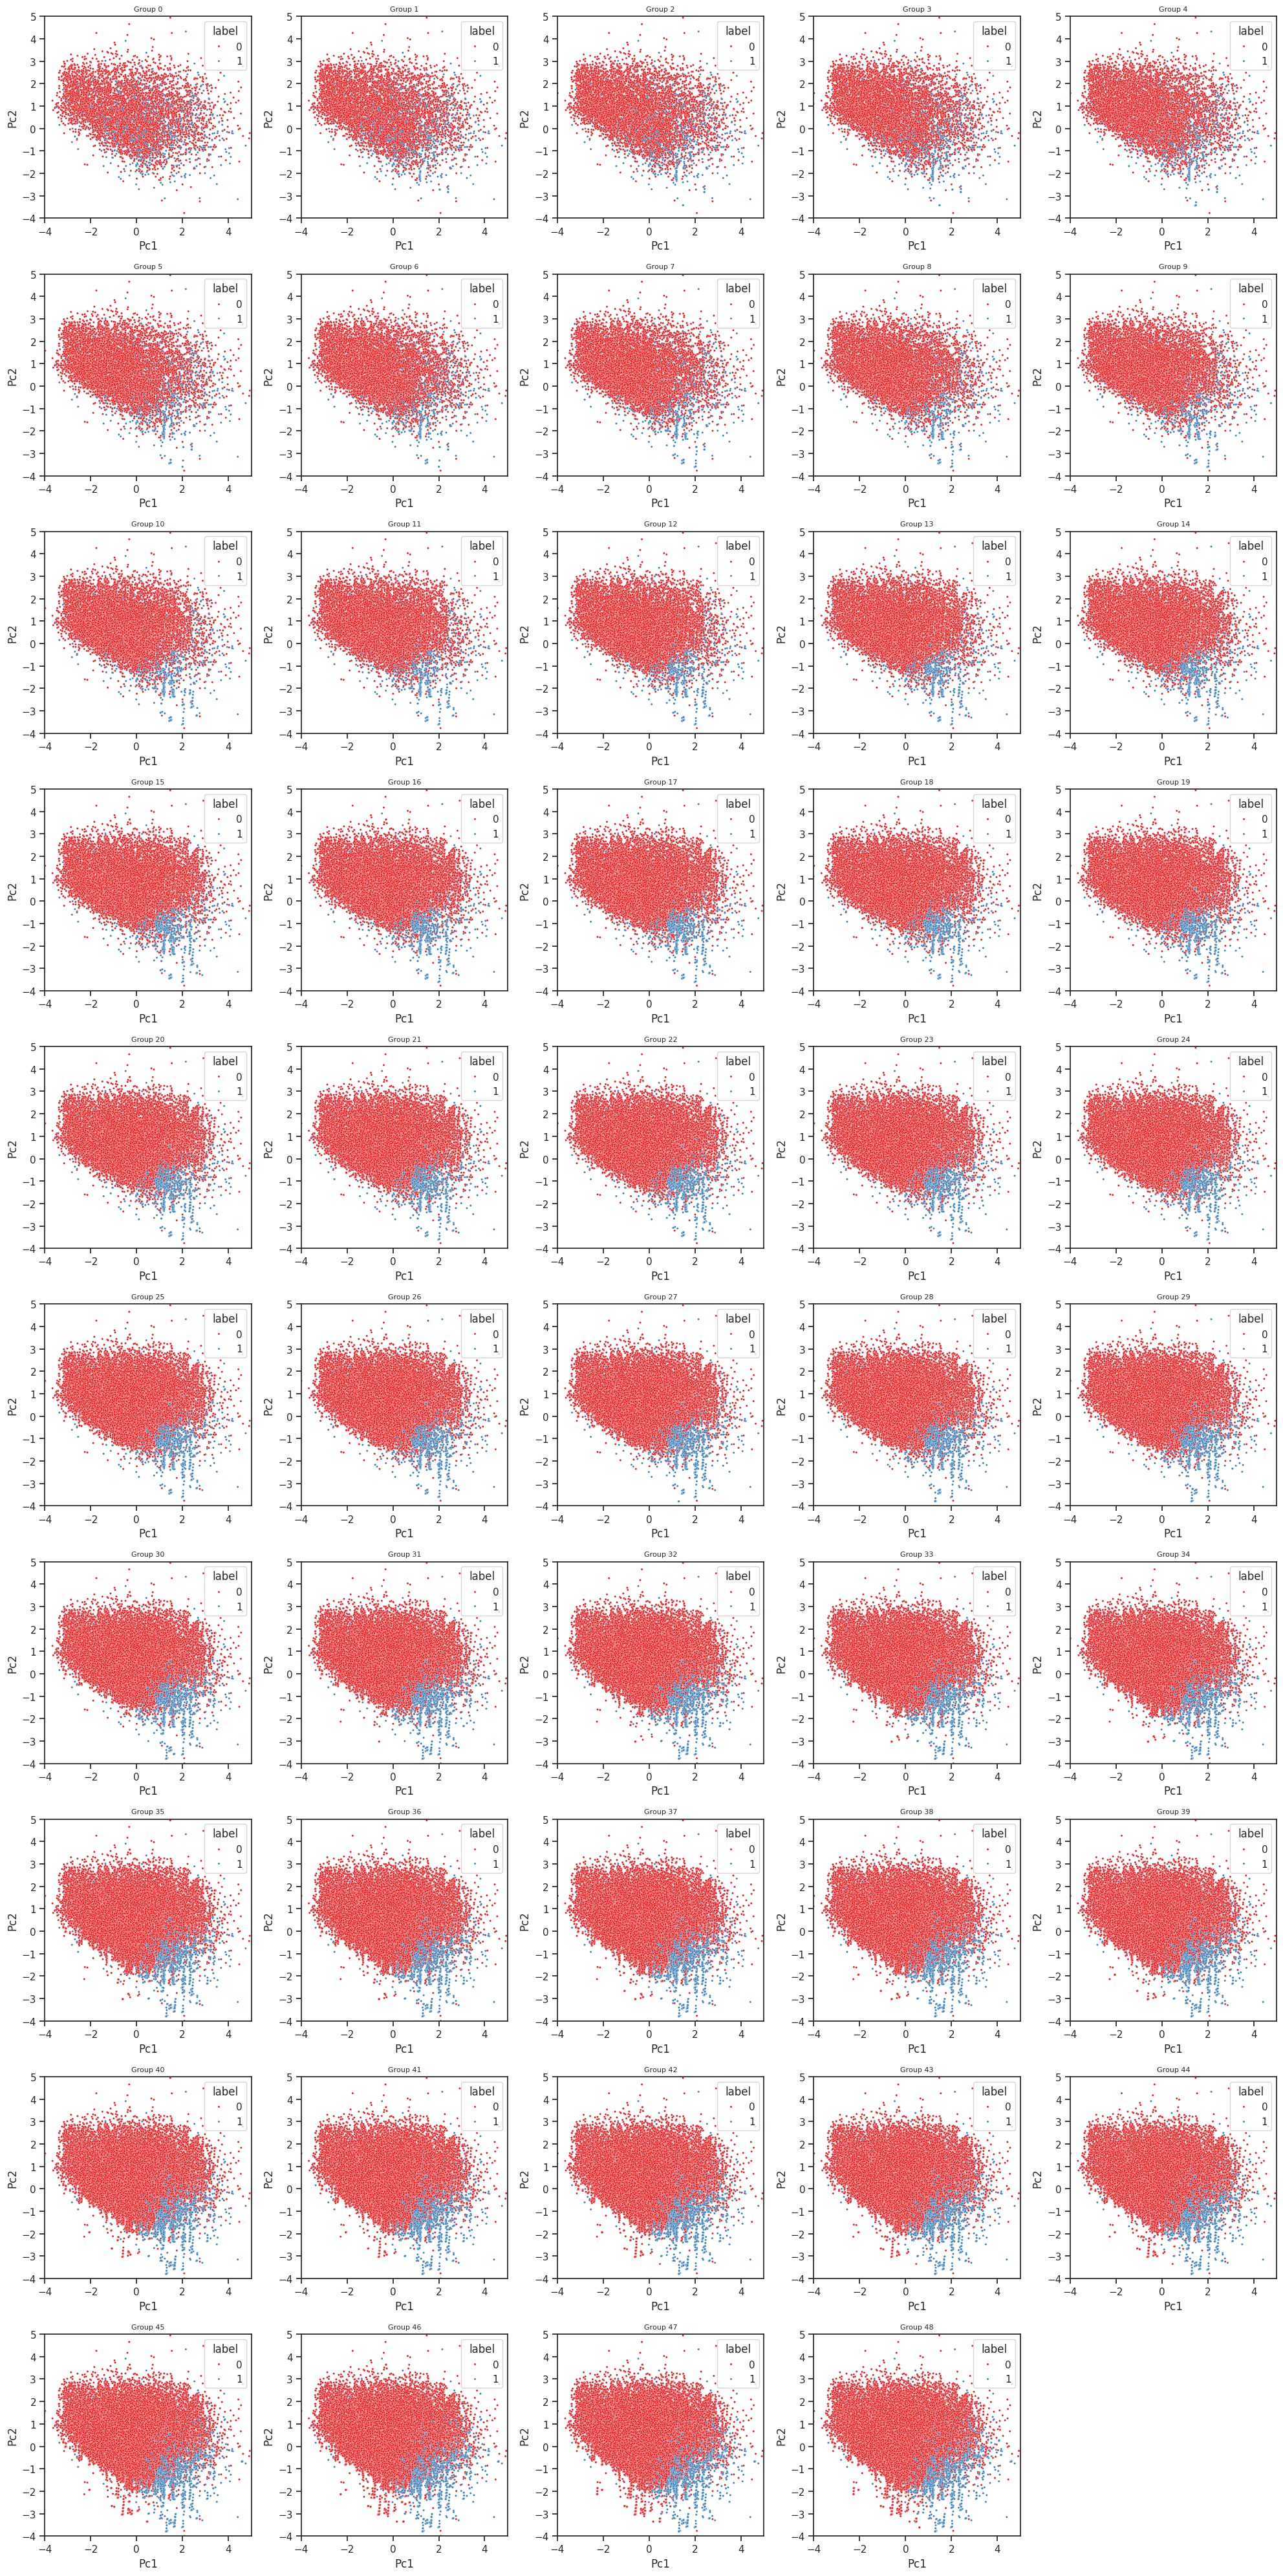

In [32]:
import math

# Define N as the total number of groups you want to plot
N = finalDf['first_it'].max()  # Number of unique first_its

# Calculate the number of rows and columns needed for the grid
n_cols = 5  # You can adjust this to your preference
n_rows = math.ceil(N / n_cols)

sns.set_theme(style="ticks")
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))  # Adjust the figure size dynamically

# Flatten the axs array for easy iteration if there are multiple rows
axs = axs.flatten()

# For each first_it, create a KDE plot
for i in range(0, N):  # Loop through the number of unique first_its
    ax = axs[i]
    sns.scatterplot(
    x="Pc1", y="Pc2", 
    data=finalDf.query(f"first_it <= {i} and label != 9999"),
    s=5,  # Change 50 to your desired dot size
    hue="label", palette="Set1", 
    ax=ax
)
    # sns.kdeplot(
    #     x="Pc1", y="Pc2", 
    #     data=finalDf.query(f"first_it <= {i} and label == 1"),
    #     cmap="Blues", fill=True, ax=ax
    # )
    ax.set_title(f'Group {i}', fontsize=8)
    ax.set_ylim([-4, 5])
    ax.set_xlim([-4, 5])

# Turn off the axes for any remaining empty subplots
for j in range(i, n_rows * n_cols):
    fig.delaxes(axs[j])

plt.tight_layout()

plt.savefig(f'pca-{seed_number}-{year}-{size}-{p_value}-{contamination_threshold}.png')
plt.show()


In [33]:
it_mean = {}
for it in range(df_i.first_it.max()):
    cols_mean = {}
    df_it  = df_i.loc[(df_i.first_it <= it) & (df_i.first_it >= 0),:]
    for c in df_i.columns:
        cols_mean[c] = df_it.loc[:,c].mean()
    it_mean[it] = cols_mean

In [34]:
mean_df = pd.DataFrame(it_mean).drop(['addr_state', 'term', 'first_it']).T
mean_df

emp_length         dti     loan_amnt  risk_score   int_rate  delinq_2yrs  \
0     4.908282   13.053928  10423.440052  684.759229  12.278685     0.146031   
1     4.592039  125.438983  10557.501685  692.726692  11.947545     0.133460   
2     4.274994  137.359993  10748.841295  696.392268  11.800910     0.126754   
3     4.089454  433.999705  10897.726035  696.771761  11.782146     0.125795   
4     3.889399  483.845290  10931.691552  694.366775  11.806601     0.125617   
5     3.759351  470.830094  11028.962137  691.965429  11.884687     0.123899   
6     3.635621  494.492224  11135.238978  688.545290  11.944990     0.121102   
7     3.524653  467.250903  11397.256212  686.645633  12.051924     0.120066   
8     3.412194  484.579582  11672.556792  686.476632  12.145863     0.118928   
9     3.319997  455.113917  12149.372979  685.319865  12.238383     0.114535   
10    3.282781  430.793817  12431.727217  684.839877  12.292584     0.111183   
11    3.277158  427.665416  12644.833033  685.033495  12.355643     0.107785   
12    3.266775  412.132974  12798.586921  685.397004  12.400353     0.105369   
13    3.254811  434.049181  13048.352379  685.885943  12.478448     0.105977   
14    3.200601  449.108745  13233.907673  686.185692  12.548700     0.109755   
15    3.176759  429.401866  13330.484433  686.061879  12.595832     0.110193   
16    3.162033  434.036348  13492.791257  685.737377  12.632738     0.110162   
17    3.137229  429.552275  13412.903235  684.722450  12.627188     0.111323   
18    3.106376  438.711601  13361.687992  684.585088  12.624489     0.111890   
19    3.066018  422.437297  13277.743322  683.756190  12.624312     0.113188   
20    3.030836  408.260941  13187.268117  681.989894  12.621435     0.113602   
21    2.992884  394.330484  13057.748055  681.076230  12.619116     0.115257   
22    2.956742  382.538501  12934.958859  680.194670  12.616483     0.117168   
23    2.937453  370.006999  12820.362202  678.939015  12.613963     0.118484   
24    2.909667  358.272530  12705.822589  676.921420  12.608689     0.117605   
25    2.887041  347.201677  12622.102951  675.186428  12.606317     0.117023   
26    2.876160  336.937777  12547.411059  674.196625  12.614385     0.117552   
27    2.852485  327.255460  12455.534819  673.912988  12.625446     0.117671   
28    2.828923  318.201649  12424.282191  673.075604  12.654933     0.117300   
29    2.811486  309.587782  12353.685352  672.375569  12.672742     0.118188   
30    2.790488  301.567030  12251.565166  670.861449  12.682505     0.118404   
31    2.769422  353.628736  12167.334921  668.633829  12.702620     0.118434   
32    2.749029  350.307271  12095.662791  666.741035  12.726743     0.118055   
33    2.730190  342.108239  11986.099431  664.533990  12.748330     0.118476   
34    2.704102  334.045130  11896.367203  662.997869  12.761710     0.119037   
35    2.672000  326.233113  11791.632691  661.438755  12.763351     0.120009   
36    2.642550  328.413898  11712.513925  660.009633  12.769685     0.120377   
37    2.609434  321.041169  11600.432645  658.094488  12.772685     0.122327   
38    2.573115  318.525653  11494.232617  656.137896  12.771452     0.123544   
39    2.528412  311.605421  11323.986227  649.519115  12.773731     0.123166   
40    2.505312  305.417372  11211.477311  647.015882  12.781045     0.123867   
41    2.479691  299.211328  11121.357742  645.058715  12.781030     0.123881   
42    2.455104  322.363027  11039.770158  641.667065  12.784308     0.123623   
43    2.428484  316.054967  10995.475439  638.840464  12.791796     0.123427   
44    2.400982  309.933317  10963.317895  633.202007  12.799741     0.124546   
45    2.370926  303.993570  10890.079017  625.856422  12.796067     0.122873   
46    2.359493  298.309967  10811.684922  619.946865  12.801193     0.121676   
47    2.351530  292.984095  10768.992913  617.638431  12.815709     0.121645   
48    2.330522  287.824208  10763.674911  614.849137  12.839787     0.122104   
49  

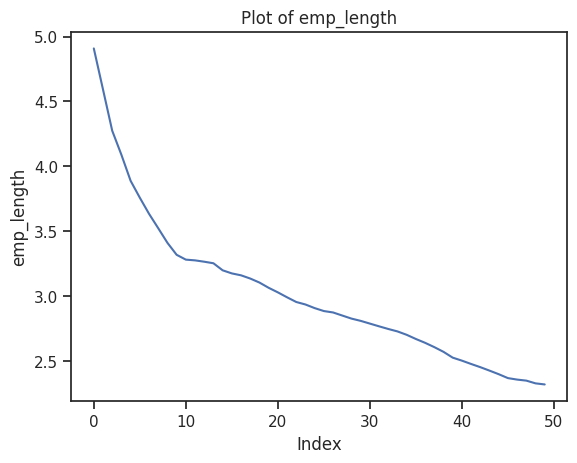

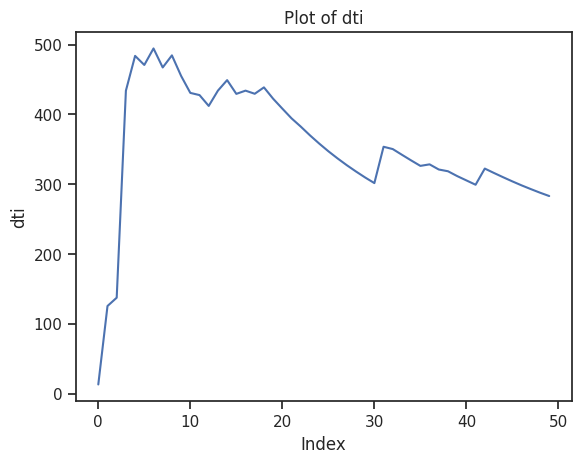

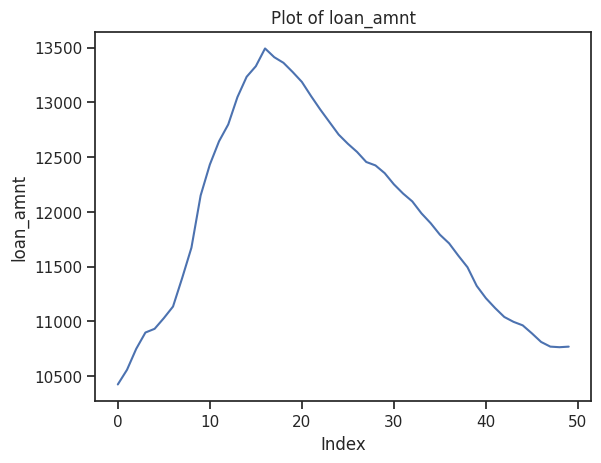

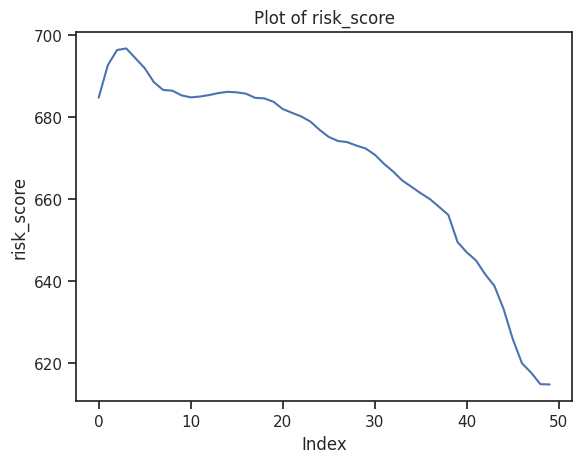

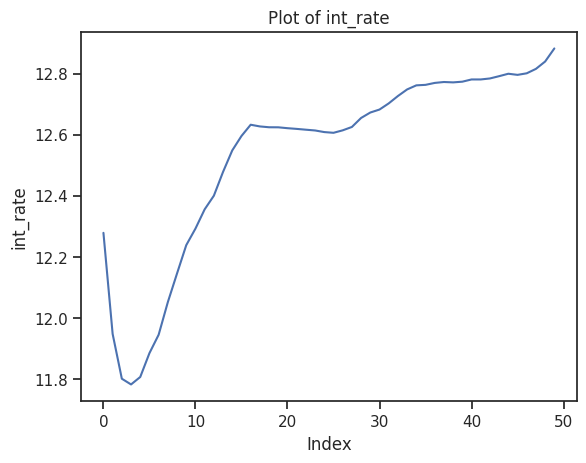

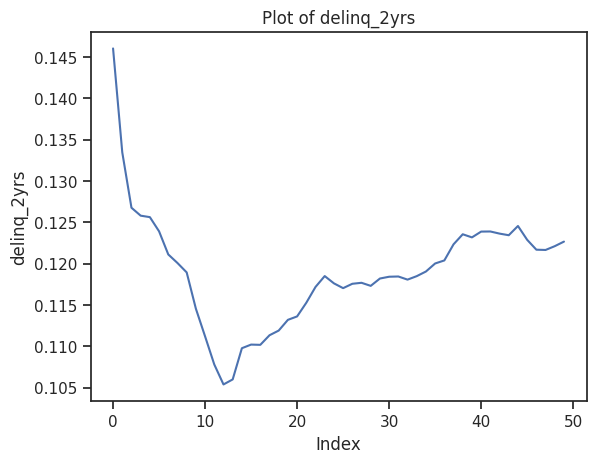

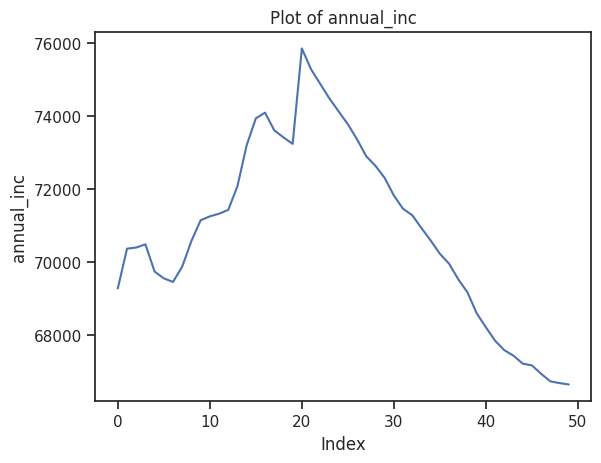

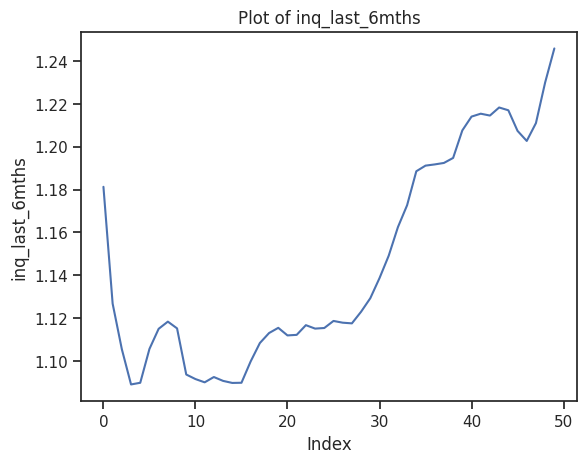

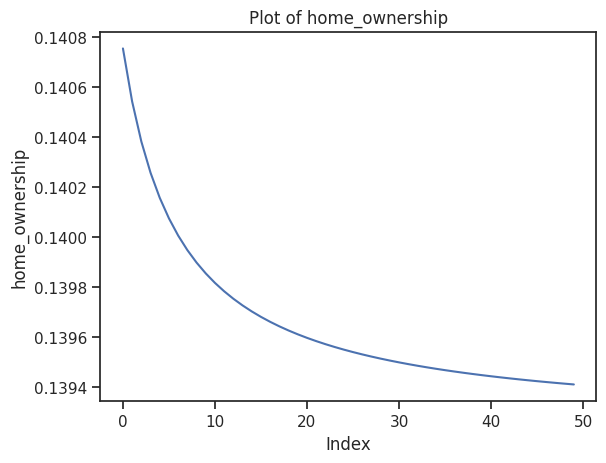

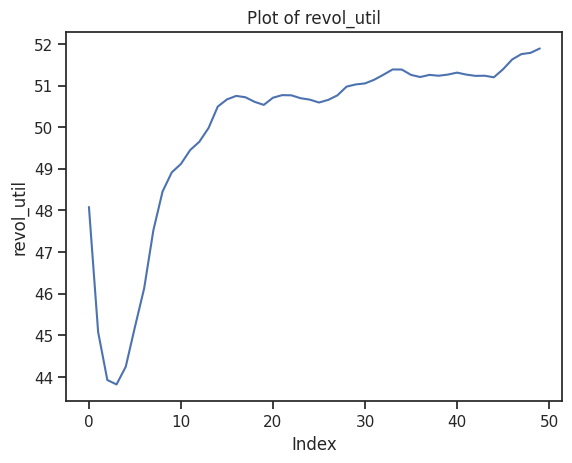

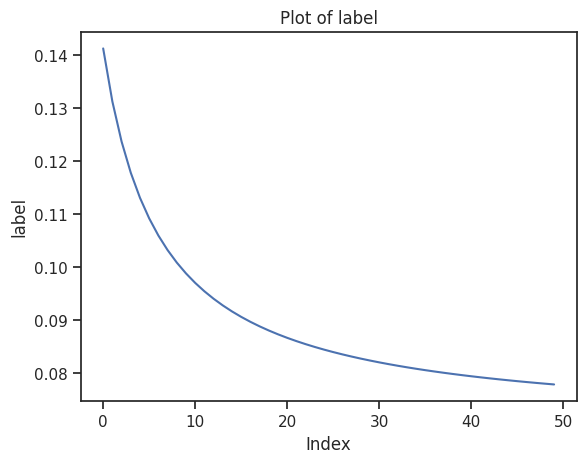

In [35]:
for column in mean_df.columns:
    plt.figure()  # Create a new figure for each plot
    plt.plot(mean_df[column])  # Plot the column data
    plt.title(f'Plot of {column}')  # Title with the name of the column
    plt.xlabel('Index')  # X-axis label, adjust if your index has specific meaning, e.g., 'Time' or 'Date'
    plt.ylabel(column)  # Y-axis label using the column name

    # Display the plot
    plt.show()


#about ci-ex

In [36]:
models_ex = os.path.join(ri_datasets_path,f'Models/TN-{year}/{seed_number}/{size}-{p_value}-{contamination_threshold}.joblib')
models_ex

'../data/riData/Models/TN-2010/388389/1000-0.07-0.12.joblib'

In [37]:
ci_ex = joblib.load(models_ex)

In [38]:
ci_ex.keys()

dict_keys(['BM', 'TN_1', 'TN_2', 'TN_3', 'TN_4', 'TN_5', 'TN_6', 'TN_7', 'TN_8', 'TN_9', 'TN_10', 'TN_11', 'TN_12', 'TN_13', 'TN_14', 'TN_15', 'TN_16', 'TN_17', 'TN_18', 'TN_19', 'TN_20', 'TN_21', 'TN_22', 'TN_23', 'TN_24', 'TN_25', 'TN_26', 'TN_27', 'TN_28', 'TN_29', 'TN_30', 'TN_31', 'TN_32', 'TN_33', 'TN_34', 'TN_35', 'TN_36', 'TN_37', 'TN_38', 'TN_39', 'TN_40', 'TN_41', 'TN_42', 'TN_43', 'TN_44', 'TN_45', 'TN_46', 'TN_47', 'TN_48', 'TN_49', 'TN_50'])

In [39]:
X_val

emp_length  addr_state    dti  loan_amnt  risk_score  int_rate  \
1642810         2.0    0.146791  13.40    25000.0       742.0     10.99   
1643590         5.0    0.146707  22.62    25000.0       702.0     15.70   
1642076        10.0    0.126354  24.38    16800.0       652.0     14.59   
1652221         7.0    0.106176  19.45     5000.0       597.0     10.38   
1639585         7.0    0.146791  13.20     5000.0       762.0      7.51   
...             ...         ...    ...        ...         ...       ...   
1644240         2.0    0.150803  11.93    12000.0       802.0      7.88   
1639242         5.0    0.118386  20.09     1000.0       712.0      7.88   
1644047        10.0    0.119596  13.80    10000.0       752.0     13.48   
1644806        10.0    0.119014   2.13     2500.0       592.0     13.92   
1644517        10.0    0.123009  21.72    24500.0       667.0     13.85   

         delinq_2yrs  annual_inc  inq_last_6mths  term  home_ownership  \
1642810          0.0   100000.00             1.0  36.0        0.150919   
1643590          0.0    68902.67             0.0  36.0        0.126405   
1642076          0.0    54000.00             3.0  36.0        0.126405   
1652221          0.0    68000.00             4.0  36.0        0.126405   
1639585          0.0    96000.00             0.0  36.0        0.126405   
...              ...         ...             ...   ...             ...   
1644240          0.0    32000.00             0.0  36.0        0.126405   
1639242          0.0    54000.00             0.0  60.0        0.126405   
1644047          0.0    41300.00             0.0  36.0        0.150919   
1644806          1.0    82400.00             0.0  36.0        0.150919   
1644517          0.0    84200.00             0.0  36.0        0.150919   

         revol_util  
1642810        67.3  
1643590        82.9  
1642076        39.8  
1652221        21.0  
1639585        17.2  
...             ...  
1644240        27.0  
1639242        32.1  
1644047        74.2  
1644806         0.0  
1644517        74.4  

[2624 rows x 12 columns]

In [40]:
from sklearn.metrics import confusion_matrix

cm_dict = {}

for name, model in ci_ex.items():
    cm = confusion_matrix(y_val, model.predict(X_val))
    cm_dict[name] = cm
       

In [41]:
cm_dict

{'BM': array([[1682,  575],
        [  70,  297]]),
 'TN_1': array([[1645,  612],
        [  68,  299]]),
 'TN_2': array([[1618,  639],
        [  67,  300]]),
 'TN_3': array([[1599,  658],
        [  65,  302]]),
 'TN_4': array([[1582,  675],
        [  62,  305]]),
 'TN_5': array([[1559,  698],
        [  62,  305]]),
 'TN_6': array([[1545,  712],
        [  57,  310]]),
 'TN_7': array([[1532,  725],
        [  57,  310]]),
 'TN_8': array([[1513,  744],
        [  58,  309]]),
 'TN_9': array([[1517,  740],
        [  52,  315]]),
 'TN_10': array([[1496,  761],
        [  52,  315]]),
 'TN_11': array([[1508,  749],
        [  50,  317]]),
 'TN_12': array([[1504,  753],
        [  50,  317]]),
 'TN_13': array([[1500,  757],
        [  51,  316]]),
 'TN_14': array([[1504,  753],
        [  51,  316]]),
 'TN_15': array([[1501,  756],
        [  49,  318]]),
 'TN_16': array([[1492,  765],
        [  49,  318]]),
 'TN_17': array([[1490,  767],
        [  51,  316]]),
 'TN_18': array([[1492

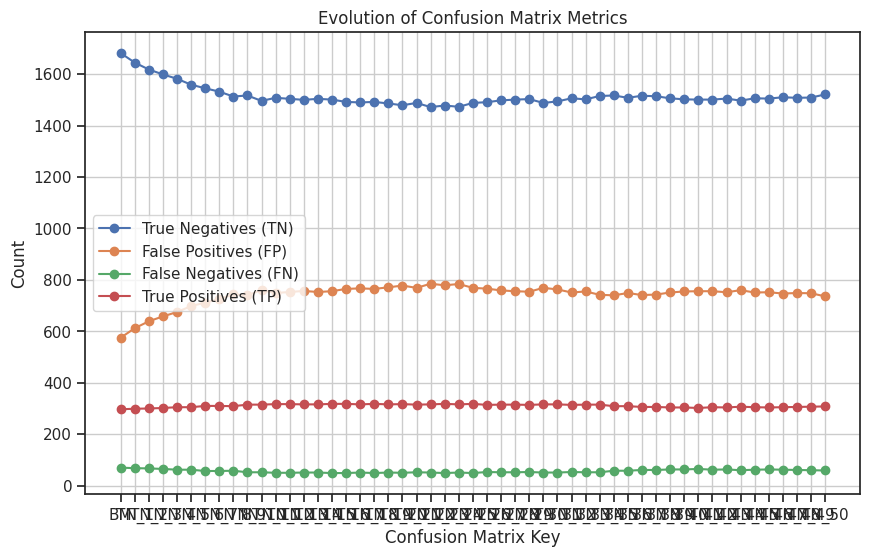

In [42]:
import matplotlib.pyplot as plt

# Confusion matrices
conf_matrices = cm_dict.copy()

# Extract TN, FP, FN, and TP
metrics = {'TN': [], 'FP': [], 'FN': [], 'TP': []}
for cm in conf_matrices.values():
    TN, FP = cm[0]
    FN, TP = cm[1]
    metrics['TN'].append(TN)
    metrics['FP'].append(FP)
    metrics['FN'].append(FN)
    metrics['TP'].append(TP)

# Plot the metrics
fig, ax = plt.subplots(figsize=(10, 6))

keys = list(conf_matrices.keys())
ax.plot(keys, metrics['TN'], label='True Negatives (TN)', marker='o')
ax.plot(keys, metrics['FP'], label='False Positives (FP)', marker='o')
ax.plot(keys, metrics['FN'], label='False Negatives (FN)', marker='o')
ax.plot(keys, metrics['TP'], label='True Positives (TP)', marker='o')

ax.set_xlabel('Confusion Matrix Key')
ax.set_ylabel('Count')
ax.set_title('Evolution of Confusion Matrix Metrics')
ax.legend()

plt.grid(True)
plt.show()
